In [55]:
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import numpy as np
from scipy import stats, special
import shap

from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.model_selection import RandomizedSearchCV

In [46]:
train = pd.read_csv('train.csv').sort_values(['time']).reset_index()#.drop(['S.No'], axis=1)
test = pd.read_csv('test.csv')

### Feature preparation

In [47]:
def features(train, test):
    train = pd.merge(train[['lon', 'Z1000']].groupby('lon').agg(['min', 'mean']).reset_index(), train, on='lon', how='left').drop([('lon', ''),'index'], axis=1)

    test = pd.merge(test[['lon', 'Z1000', ]].groupby('lon').agg(['min', 'mean']).reset_index(), test, on='lon', how='left').drop([('lon', '')], axis=1)
    train.rename(columns={('Z1000', 'min'): 'Z1000_min', ('Z1000', 'max'): 'Z1000_max', ('Z1000', 'mean'):'Z1000_mean', #('T500', 'mean'):'T500_mean', ('T500', 'max'):'T500_max', ('T500', 'min'):'T500_min'
                         }, inplace=True)
    test.rename(columns={('Z1000', 'min'): 'Z1000_min', ('Z1000', 'max'): 'Z1000_max', ('Z1000', 'mean'):'Z1000_mean', #('T500', 'mean'):'T500_mean', ('T500', 'max'):'T500_max', ('T500', 'min'):'T500_min'
                         }, inplace=True)
    return train, test
train, test= features(train, test)
X_train, X_test, y_train, y_test = train_test_split(train.drop(['S.No','time','LABELS'], axis=1), train['LABELS'], test_size=0.33, random_state=42)



merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)


#### Light gbm

In [64]:
model = LGBMClassifier(objective="multiclass" ,class_weight={0:0.2,1:0.45,2:0.35},
                       metric="multi_logloss", random_state=42, num_class=3,
                       min_gain_to_split=0.3,
                       
                       #min_split_gain = 23
                      )
model.fit(X_train, y_train)
ypred = model.predict(X_test)
y_tr_pred = model.predict(X_train)

[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3


In [63]:
print(classification_report(y_test, ypred), "Test training accuracy")

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     12386
           1       0.69      0.79      0.73       635
           2       0.69      0.79      0.73      2740

    accuracy                           0.88     15761
   macro avg       0.77      0.83      0.80     15761
weighted avg       0.89      0.88      0.88     15761
 Test training accuracy


In [52]:
print(classification_report(y_train, y_tr_pred), "Train training accuracy")

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     25149
           1       0.73      0.90      0.81      1367
           2       0.73      0.84      0.78      5483

    accuracy                           0.90     31999
   macro avg       0.81      0.89      0.84     31999
weighted avg       0.91      0.90      0.91     31999
 Train training accuracy


#### Learning curve
Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

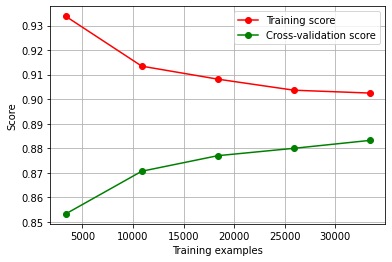

In [53]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

train_sizes, train_scores, test_scores = learning_curve(model, train.drop(['S.No','time','LABELS'], axis=1) , train['LABELS'], cv=cv, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()


plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


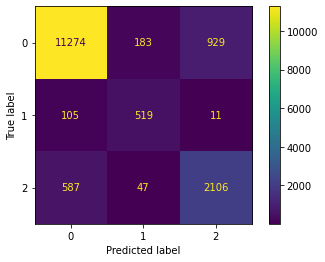

[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGB

[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGB

In [54]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

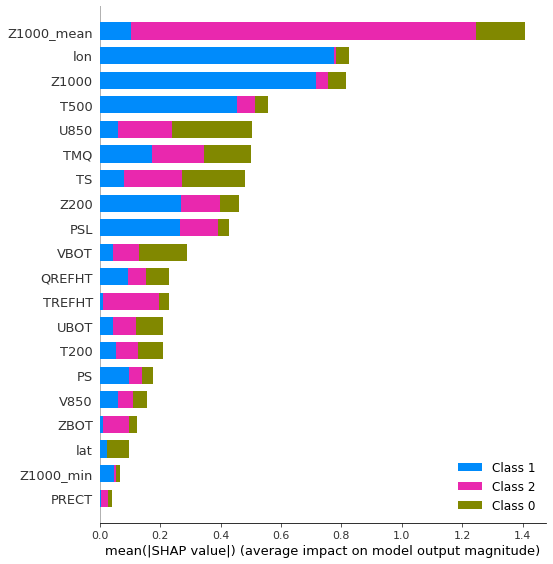

In [9]:
### Shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

#### Random forest

In [10]:

from sklearn.ensemble import RandomForestClassifier
seed = 1234
clf = RandomForestClassifier(n_estimators=250, 
                                max_depth=7, 
                                max_features='sqrt', 
                                random_state=seed, min_samples_leaf = 10)

clf.fit(X_train, y_train)
print(classification_report(y_train, clf.predict(X_train)))
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     25149
           1       0.87      0.52      0.65      1367
           2       0.79      0.50      0.61      5483

    accuracy                           0.87     31999
   macro avg       0.85      0.66      0.73     31999
weighted avg       0.86      0.87      0.86     31999

              precision    recall  f1-score   support

           0       0.87      0.96      0.92     12386
           1       0.82      0.48      0.61       635
           2       0.76      0.47      0.58      2740

    accuracy                           0.86     15761
   macro avg       0.82      0.64      0.70     15761
weighted avg       0.85      0.86      0.85     15761



In [11]:
from sklearn.ensemble import GradientBoostingClassifier
l1_clf1 = GradientBoostingClassifier(n_estimators=400,
                                    learning_rate=0.006,
                                    min_samples_leaf=10,
                                    max_depth=12, 
                                    max_features='sqrt', 
                                    subsample=0.85,
                                    random_state=seed)
l1_clf1.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.006, max_depth=12,
                           max_features='sqrt', min_samples_leaf=100,
                           n_estimators=400, random_state=1234, subsample=0.85)

In [12]:
print(classification_report(y_train, l1_clf1.predict(X_train)))
print(classification_report(y_test, l1_clf1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     25149
           1       0.85      0.68      0.75      1367
           2       0.84      0.67      0.75      5483

    accuracy                           0.91     31999
   macro avg       0.87      0.77      0.82     31999
weighted avg       0.90      0.91      0.90     31999

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     12386
           1       0.78      0.61      0.69       635
           2       0.79      0.60      0.68      2740

    accuracy                           0.88     15761
   macro avg       0.82      0.72      0.77     15761
weighted avg       0.88      0.88      0.88     15761



#### Hyperparameter tuning


In [60]:
##Lightgbm
mdl = LGBMClassifier(objective="multiclass" ,class_weight={0:0.2,1:0.45,2:0.35},
                       metric="multi_logloss", random_state=42, num_class=3,
                       
                       #min_split_gain = 23
                      )
param1 = {'min_gain_to_split':[0.1, 0.3, 0.5, 0.6]}
clf = RandomizedSearchCV(mdl, param1, random_state=42, cv=5)

clf.fit(X_train, y_train)

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3
[LightGB

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 0.2, 1: 0.45,
                                                          2: 0.35},
                                            metric='multi_logloss', num_class=3,
                                            objective='multiclass',
                                            random_state=42),
                   param_distributions={'min_gain_to_split': [0.1, 0.3, 0.5,
                                                              0.6]},
                   random_state=42)

In [61]:
clf.best_estimator_

LGBMClassifier(class_weight={0: 0.2, 1: 0.45, 2: 0.35}, metric='multi_logloss',
               min_gain_to_split=0.1, num_class=3, objective='multiclass',
               random_state=42)

In [ ]:
##random forest
mdl = RandomForestClassifier(n_estimators=250, 
                                
                                max_features='sqrt', 
                                random_state=seed, )
param1 = {'max_depth':[5, 6, 7], 'min_samples_leaf':[5, 10, 15, 20]}
clf = RandomizedSearchCV(mdl, param1, random_state=42, cv=5)

clf.fit(X_train, y_train)
clf.best_estimator_

In [ ]:
mdl = GradientBoostingClassifier(n_estimators=400,
                                    learning_rate=0.006,
                                    max_depth=12, 
                                    max_features='sqrt', 
                                    subsample=0.85,
                                    random_state=seed)
param1 = {'learning_rate':[0.001, 0.003, 0.006, 0.01], 'max_depth':[5, 10, 15, 20], 'min_samples_leaf':[5, 10, 15, 20]}
clf = RandomizedSearchCV(mdl, param1, random_state=42, cv=5)

clf.fit(X_train, y_train)
clf.best_estimator_